# Embedding multiple networks

Often, we are interested in more than one network. Sometimes this arises from thinking
about multiple "layers," where each layer represents a different kind of relationship.

```{figure} ./images/stacked-adj.png
Example of a multiple-layered network (multigraph) from the *Drosophila* larva brain 
connectome.
```

Or, we may have networks which arise from the same process, but at different timepoints. 

Regardless of the data, it is common to want to:
- Generate a single embedding which summarizes the property of each node, regardless
of which network it came from, or
- Compare the role of each node across networks, or
- Quantitatively compare the networks themselves

Each of these tasks (and many others) can benefit from doing network embeddings which
somehow deal with multiple networks. We'll discuss a few approaches and considerations
below, mainly for the spectral methods.


## Do a couple of spectral embeddings

Let's say we have two networks. We wish to come up with an embedding for *each node
in each network*. Since we've already learned about techniques for network embedding, 
why not just apply these techniques separately to each network, and compare the results?

In [34]:
import networkx as nx
import pandas as pd 
from pathlib import Path
from graspologic.utils import symmetrize


DATA_PATH = Path("networks-course/data")

def load_matched(side="left"):
    side = side.lower()
    dir = DATA_PATH / "processed_maggot"
    g = nx.read_edgelist(
        dir / f"matched_{side}_edgelist.csv",
        create_using=nx.DiGraph,
        delimiter=",",
        nodetype=int,
    )
    nodes = pd.read_csv(dir / f"matched_{side}_nodes.csv", index_col=0)
    adj = nx.to_numpy_array(g, nodelist=nodes.index)
    return adj, nodes

left_adj, left_nodes = load_matched('left')
right_adj, right_nodes = load_matched('right')
left_adj = symmetrize(left_adj)
right_adj = symmetrize(right_adj)


In [42]:
from graspologic.embed import AdjacencySpectralEmbed

ase = AdjacencySpectralEmbed(n_components=8)
X_left= ase.fit_transform(left_adj)
X_right = ase.fit_transform(right_adj)

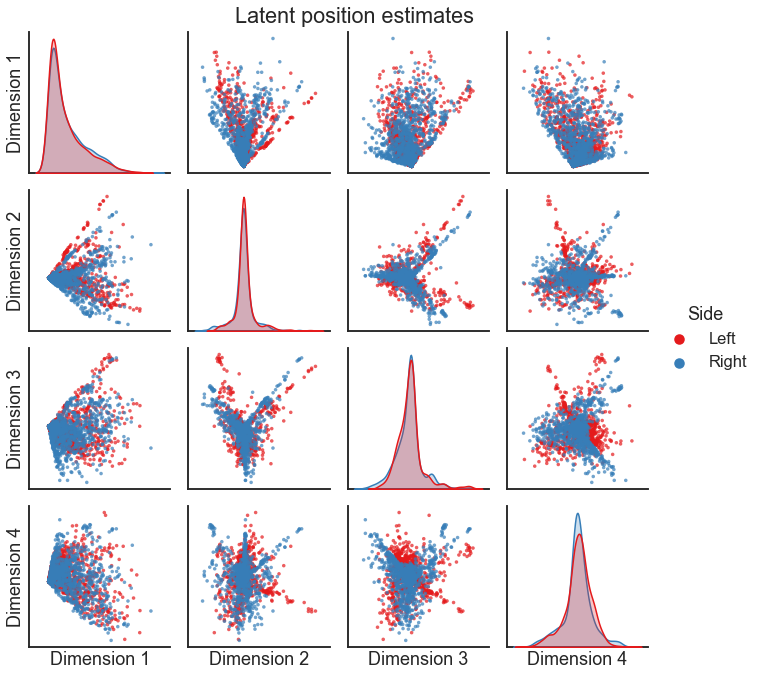

In [43]:
import numpy as np
from graspologic.plot import pairplot

X_both = np.concatenate((X_left, X_right), axis=0)
labels = np.array(len(X_left)*['Left'] + len(X_right)*['Right'])

pairplot(X_both[:, :4], labels, legend_name='Side', title='Latent position estimates')

```{admonition} Question
:class: tip

Based on this plot, would you say that these networks are similar? Why or why not?

Do you notice anything about the relationship of one embedding with regard to the 
other? 
```

## Orthogonal nonidentifiability

Earlier in the course, we discussed a model with a nonidentifiability in its parameters.
As a reminder, this just means that we have some flexibility in the parameters we use
which gives us the same model behavior. Can this arise for the RDPG model, which is the
motivation behind doing ASE? Let's have a look. 

Remember that for the RDPG, we are using the model of $A$ being sampled from a
probability matrix, $P$. $P$ has the structure

$$P = XX^T$$

for an undirected network, or for a directed network, 

$$P = XY^T$$

How can a nonidentifiability pop up here? Note that an [**orthogonal matrix**](https://en.wikipedia.org/wiki/Orthogonal_matrix) $W$ is one 
such that

$$W W^T = W^T W = I$$

Intuitively, these orthogonal matrices represent *rotations* and *reflections* in our 
$d$-dimensional space. They are often called **isometric** transformations of the space,
because they *preserve all interpoint distances*.

Text(0.5, 1.0, 'Transformed positions ($X W$)')

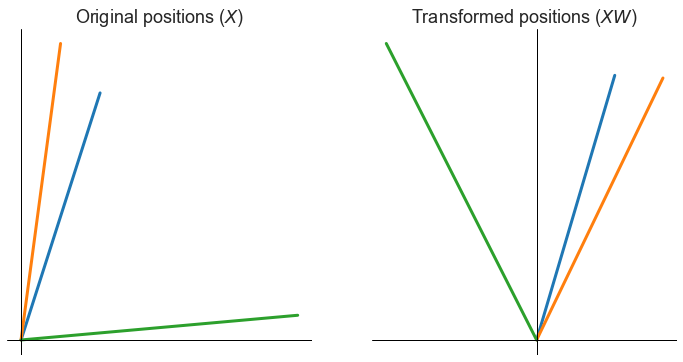

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_context('talk')

X = np.array([[0.2, 0.5], [0.1, 0.6], [0.7, 0.05]])

fig, axs = plt.subplots(1,2,figsize=(12,6))

ax = axs[0]
for row in X:
    ax.plot([0.0, row[0]], [0.0, row[1]], linewidth=3)

ax.axis('off')
ax.axvline(0, color='black', linewidth=1)
ax.axhline(0, color='black', linewidth=1)
ax.set_title(r"Original positions ($X$)")

from scipy.stats import ortho_group

np.random.seed(888)
W = ortho_group.rvs(2)

Z = X @ W

ax = axs[1]
for row in Z:
    ax.plot([0.0, row[0]], [0.0, row[1]], linewidth=3)

ax.axis('off')
ax.axvline(0, color='black', linewidth=1)
ax.axhline(0, color='black', linewidth=1)
ax.set_title(r"Transformed positions ($X W$)")


Note that the distances between all points is preserved.

```{admonition} Question
:class: tip

Can you think of another set of latent positions, say $Z$, such that or probability
matrix $P = XX^T = ZZ^T$, but $Z \neq X$? 

Hint: where can you insert some orthogonal matrices into the formula $P = XX^T$ such 
that the matrix $P$ is unchanged?
```


Note what this means for our embeddings:

In [45]:
W = ortho_group.rvs(X_left.shape[1])
X_left_new = X_left @ W
P1 = X_left @ X_left.T
P2 = X_left_new @ X_left_new.T

np.isclose(P1, P2).all()

True

We have just found two sets of latent positions which are equally valid - but note that
there are an *infinite* number of orthogonal transformations. 

## Orthogonal procrustes problem

In practice, how can we resolve this issue? Let's say we have these two sets of latent
positions and want to somehow compare them on equal footing. What we can do is try to 
uncover a orthogonal transformation of one set of latent positions with regard to the
other, e.g.

$$X^{(1)} \text{ vs. } X^{(2)} W$$

for some $W$.

```{admonition} Question
What would be a good way to measure the distance between $X^{(1)}$ and $X^{(2)} W$?
```

We arrive at the problem

$$\min_{W: WW^T=W^TW=I} \|X^{(1)} - X^{(2)} W\|_F$$

This is a very old and famous problem known as the [**orthogonal Procrustes problem**](https://en.wikipedia.org/wiki/Orthogonal_Procrustes_problem), 
and it has an exact solution (fun fact: the solution uses the SVD).

We can apply the Procrustes solution using [`scipy.linalg.orthogonal_procrustes`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.orthogonal_procrustes.html) or a wrapper in `graspologic`, the [`OrthogonalProcrustes`](https://microsoft.github.io/graspologic/latest/reference/reference/align.html#orthogonal-procrustes) class.

In [46]:
from graspologic.align import OrthogonalProcrustes

op = OrthogonalProcrustes()
X_right_pred = op.fit_transform(X_right, X_left)

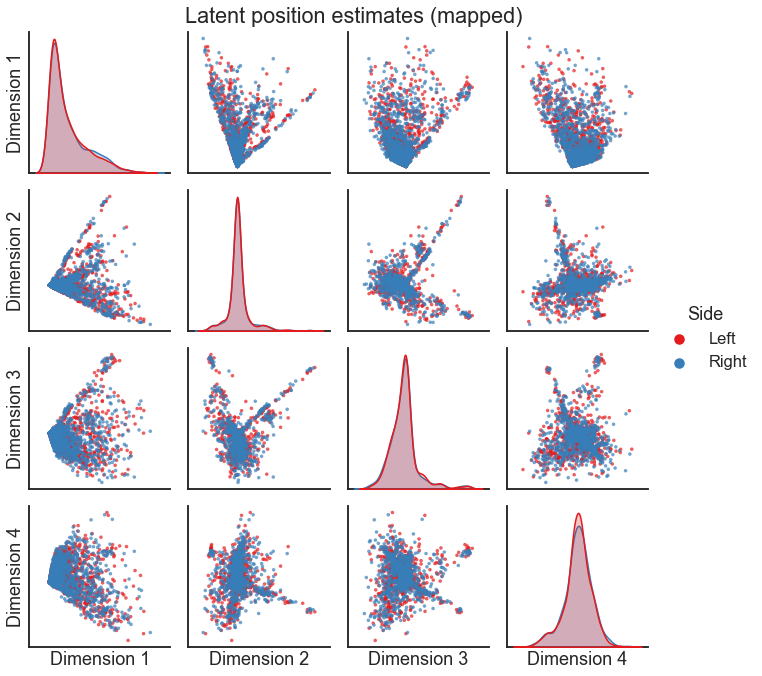

In [47]:
X_both = np.concatenate((X_left, X_right_pred), axis=0)

pairplot(X_both[:, :4], labels, legend_name='Side', title='Latent position estimates (mapped)')

```{admonition} Question
:class: tip 

Looking at these embeddings, would you say these networks are similar or different, at 
least at a high level? 
```